In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
df=pd.read_csv('train.csv')

In [5]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [6]:
df.shape

(750000, 9)

In [7]:
df.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

__Linear Regression__

In [38]:
df2=pd.get_dummies(df,columns=['Sex']).astype(int)
df2.drop('id',axis=1,inplace=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
inputs=df2.drop(columns=['Calories'])
target=df['Calories']

In [11]:
lin_reg=LinearRegression()
x_train,x_test,y_train,y_test=train_test_split(inputs,target,test_size=0.3)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)


In [13]:
lin_reg=LinearRegression()
lin_reg.fit(x_train_scaled,y_train)

LinearRegression()

In [14]:
lin_reg.score(x_test_scaled,y_test)

0.9663947964615931

In [15]:
from sklearn.metrics import mean_squared_log_error

y_train_pred = lin_reg.predict(x_train_scaled)
y_val_pred = lin_reg.predict(x_test_scaled)

y_train_pred = np.maximum(0, y_train_pred)
y_val_pred = np.maximum(0, y_val_pred)

train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_test, y_val_pred))

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {val_rmsle:.4f}")


Training RMSLE: 0.5912
Validation RMSLE: 0.5892


____Random Forest____

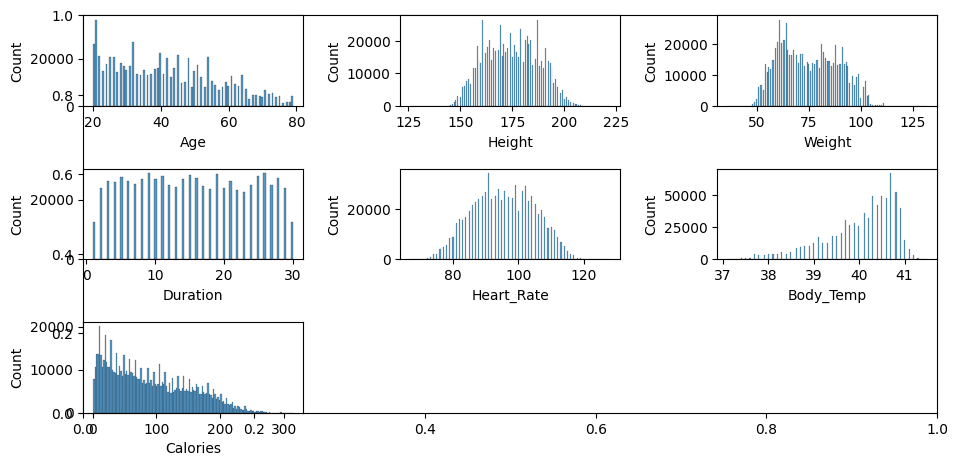

In [16]:
plt.subplots(figsize=(10,5))
for i,col in enumerate(df.columns[2:]):
    plt.subplot(3,3,i+1)
    sb.histplot(df[col])
plt.tight_layout()
plt.show()

<Axes: >

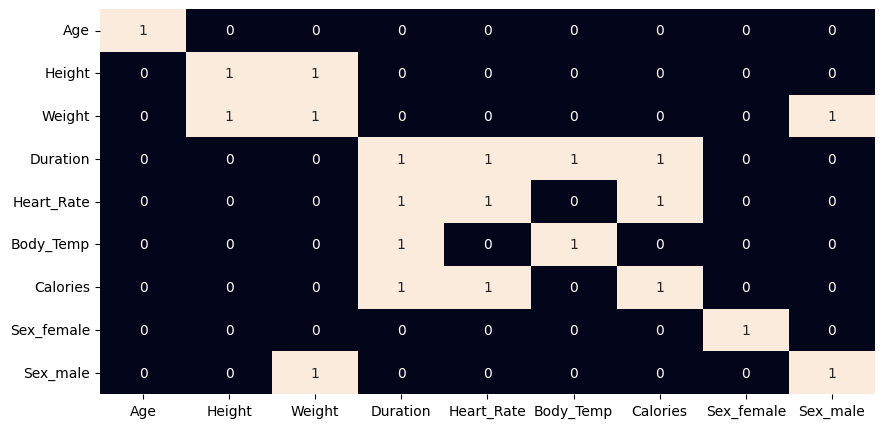

In [17]:
plt.figure(figsize=(10,5))
sb.heatmap(df2.corr()>0.8,annot=True,cbar=False)

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [20]:
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train, y_train)


print("Best parameters found: ", random_search.best_params_)
print("Best RMSE: ", np.sqrt(-random_search.best_score_))

best_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best RMSE:  3.6599073416067895


In [21]:
from sklearn.metrics import mean_squared_log_error

In [22]:
best_model.fit(x_train,y_train)
y_train_pred = best_model.predict(x_train)
y_val_pred = best_model.predict(x_test)

In [23]:
from sklearn.metrics import mean_squared_log_error

y_train_pred = np.maximum(0, y_train_pred)
y_val_pred = np.maximum(0, y_val_pred)

train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
val_rmsle = np.sqrt(mean_squared_log_error(y_test, y_val_pred))

print(f"Training RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {val_rmsle:.4f}")


Training RMSLE: 0.0628
Validation RMSLE: 0.0638


__Submission__

In [48]:
submission=pd.read_csv('sample_submission.csv')
df_test=pd.read_csv('test.csv')
X_test_final=df_test.drop(['id'],axis=1)
X_test_final=pd.get_dummies(X_test_final,columns=['Sex']).astype(int)
X_test_final

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_female,Sex_male
0,45,177,81,7,87,39,0,1
1,26,200,97,20,101,40,0,1
2,29,188,85,16,102,40,1,0
3,39,172,73,20,107,40,1,0
4,30,173,67,16,94,40,1,0
...,...,...,...,...,...,...,...,...
249995,56,159,62,6,85,39,1,0
249996,32,202,101,3,84,38,0,1
249997,31,164,64,14,98,40,1,0
249998,62,158,61,25,106,40,1,0


In [49]:
y_pred = best_model.predict(X_test_final)

In [54]:
submission = pd.read_csv("sample_submission.csv")
submission['Calories'] = np.maximum(0, y_pred)  
submission.to_csv("submission.csv", index=False)